<a href="https://colab.research.google.com/github/shgyg99/handwrittenmathsolutions/blob/main/mathTOlatex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🔴ENVIRONMENT SETUP**

In [3]:
!pip install -q torchmetrics
!pip install -q wandb
!pip install -q fastai

In [6]:
!pip uninstall torchvision torch -y
!pip install torch==2.5 torchvision==0.20

  Using cached torch-2.5.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 869.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

# **🔴IMPORT LIBS**

In [47]:
import warnings
warnings.filterwarnings('ignore')

import os
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms as TT
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch.nn import functional as F

import wandb
import tqdm
import torchmetrics as tm
from PIL import Image

# **🔴UTILS**

In [2]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [4]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# **🔴ARGUMENTS**

In [9]:
seed = 8
path = '/content/drive/MyDrive/papersFolder'
embed_size=256
hidden_size=512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.5
batch_size=128
lr = 1e-2
momentum=0.9
num_epoch = 10
wandb_enable = False
seq_len = 20

In [7]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

# **🔴CUSTOM DATASET**

In [46]:
class LatexImages(Dataset):
  def __init__(self, path, image_transform=None, target_transform=None):
    self.path = path
    self.image_transform = image_transform
    self.target_transform = target_transform

    csv = pd.read_csv(os.path.join(self.path, 'merged_sorted.csv'))

    self.image_paths = []
    self.labels = []
    for i in os.listdir(os.path.join(self.path, 'cropped')):
        image_path = fr'.\cropped\{i}'
        try:
          label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
          self.image_paths.append(os.path.join(self.path, 'cropped', i))
          self.labels.append(label)
        except:
          pass


  def __getitem__(self, index):
    image_path = self.image_paths[index]

    if self.target_transform:
      label = self.target_transform(self.labels[index])
    else:
      label = self.labels[index]

    if self.image_transform:
      image = self.image_transform(Image.open(image_path))
    else:
      image = Image.open(image_path)

    return image, label

  def __len__(self):
    return len(self.image_paths)

In [48]:
dataset = LatexImages(path=path)

\frac{\left|2\times1-5\times-4+0\right|}{\sqrt{4+25}}


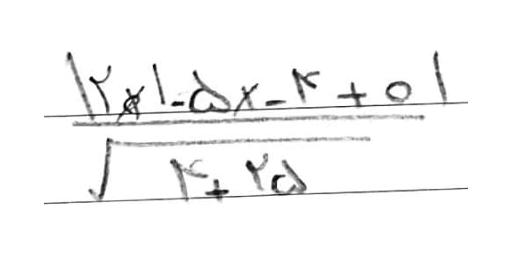

In [66]:
im, la = dataset.__getitem__(np.random.randint(0, dataset.__len__()))
print(la)
im


In [67]:
la.split()

['\\frac{\\left|2\\times1-5\\times-4+0\\right|}{\\sqrt{4+25}}']

In [71]:
csv = pd.read_csv('/content/drive/MyDrive/papersFolder/merged_sorted.csv')
final = csv['LaTeX Label'].to_list()

In [78]:
['$', '\\', '{', '}', '^', '+', '-',
 "'",'_', '!', '.', '/', '&', '%', '*',
 'frac', 'times', 'lim', 'sin', 'cos',
 'tan', 'cot', 'csc', 'sec', 'sqrt',
 'sum', 'rightarrow', 'Rightarrow',
 'leftarrow', 'Leftarrow',
 'right', 'left', 'alpha', 'beta', '|',
 'Delta', 'delta', 'gamma', 'lambda',
 'min', 'max', '(', ')', '<', '>', '=',
 'pm', 'mp', 'neq', 'infty', 'matrix',
 '[', ']', 'in', 'notin', 'cap', 'cup',
 'begin', 'end', 'dots', 'int', ':', 'ln',
 'pi', 'theta', 'to', 'arctan', 'arccot', 'arcsin', 'arccos',
 'log', 'sinh', 'cosh', 'coth', 'tanh', 'degree', 'dev', 'sim',
 'forall', 'emptyset', 'buildrelF', 'bar', 'exists', 'varepsilon', 'partial',
 'hat', 'triangle', 'mathbb', 'simeq', ''
 ]

['$',
 '\\',
 '{',
 '}',
 '^',
 '+',
 '-',
 "'",
 '_',
 '!',
 '.',
 '/',
 '&',
 '%',
 '*',
 'frac',
 'times',
 'lim',
 'sin',
 'cos',
 'tan',
 'cot',
 'csc',
 'sec',
 'sqrt',
 'sum',
 'rightarrow',
 'Rightarrow',
 'leftarrow',
 'Leftarrow',
 'right',
 'left',
 'alpha',
 'beta',
 '|',
 'Delta',
 'delta',
 'gamma',
 'lambda',
 'min',
 'max',
 '(',
 ')',
 '<',
 '>',
 '=',
 'pm',
 'mp',
 'neq',
 'infty',
 'matrix',
 '[',
 ']',
 'in',
 'notin',
 'cap',
 'cup',
 'begin',
 'end',
 'dots',
 'int',
 ':',
 'ln',
 'pi',
 'theta',
 'to',
 'arctan',
 'arccot',
 'arcsin',
 'arccos',
 'log',
 'sinh',
 'cosh',
 'coth',
 'tanh',
 'degree',
 'dev',
 'sim',
 'forall',
 'emptyset',
 'buildrelF',
 'bar',
 'exists',
 'varepsilon',
 'partial',
 'hat',
 'triangle',
 'mathbb',
 'simeq',
 '']